In [127]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [128]:
dataset = pd.read_csv('costsensitiveregression.csv')

In [129]:
dataset.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [130]:
dataset.columns

Index(['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN', 'Status', 'FNC'],
      dtype='object')

In [131]:
X = dataset[['NotCount', 'YesCount', 'ATPM', 'PFD', 'PFG', 'SFD', 'SFG', 'WP', 'WS',
       'AH', 'AN']]
Y = dataset['Status']
FN = dataset['FNC']

In [132]:
X_ten = torch.tensor(X.values, dtype=torch.float32)
Y_ten = torch.tensor(Y.values, dtype=torch.float32)

TP_ten = torch.tensor([4 for i in range(len(Y_ten))], dtype=torch.float32)
FP_ten = torch.tensor([4 for i in range(len(TP_ten))], dtype=torch.float32)
TN_ten = torch.tensor([0 for i in range(len(TP_ten))], dtype=torch.float32)
FN_ten = torch.tensor(FN.values, dtype=torch.float32)


In [133]:
# performing test-train 80-20
indices = np.arange(len(dataset) , dtype = np.int64)
np.random.shuffle(indices)

train_indices = indices[:int(len(dataset)*0.8)].tolist()
test_indices = indices[int(len(dataset)*0.8):].tolist()

In [134]:
X_train = X_ten[train_indices]
Y_train = Y_ten[train_indices].reshape(-1,1)
X_test = X_ten[test_indices]
Y_test = Y_ten[test_indices].reshape(-1,1)

TP_train = TP_ten[train_indices].reshape(-1,1)
TP_test = TP_ten[test_indices].reshape(-1,1)
FP_train = FP_ten[train_indices].reshape(-1,1)
FP_test = FP_ten[test_indices].reshape(-1,1)
TN_train = TN_ten[train_indices].reshape(-1,1)
TN_test = TN_ten[test_indices].reshape(-1,1)
FN_train = FN_ten[train_indices].reshape(-1,1)
FN_test = FN_ten[test_indices].reshape(-1,1)

In [135]:
class CostSensitiveRegression(nn.Module):
    def __init__(self , input_dim , output_dim):
        super(CostSensitiveRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim , output_dim)
        
    def forward(self, x):
        
        return torch.sigmoid(self.fc1(x))

In [136]:
def CostSensitiveLoss(y, y_hat, tp, fp, fn, tn):
    loss = torch.mean(y * (y_hat * tp + (1 - y_hat) * fn) + (1 - y) * (y_hat * fp + (1 - y_hat) * tn))
    loss.requires_grad_()
    return loss

Epoch 1 : Train Loss = 30.371278762817383 , Test Loss = 39.37268829345703
Epoch 2 : Train Loss = 27.423795700073242 , Test Loss = 36.28511047363281
Epoch 3 : Train Loss = 24.7625789642334 , Test Loss = 33.50606918334961
Epoch 4 : Train Loss = 22.35785484313965 , Test Loss = 31.000225067138672
Epoch 5 : Train Loss = 20.183218002319336 , Test Loss = 28.72590446472168
Epoch 6 : Train Loss = 18.21501350402832 , Test Loss = 26.644792556762695
Epoch 7 : Train Loss = 16.43131446838379 , Test Loss = 24.72381591796875
Epoch 8 : Train Loss = 14.812590599060059 , Test Loss = 22.93465232849121
Epoch 9 : Train Loss = 13.343155860900879 , Test Loss = 21.253658294677734
Epoch 10 : Train Loss = 12.011892318725586 , Test Loss = 19.66217041015625


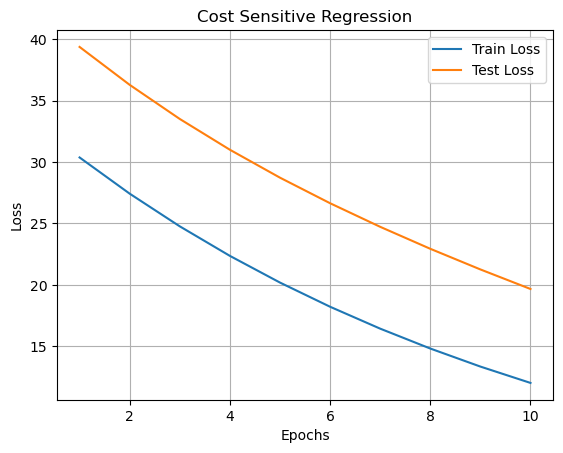

In [137]:
epochs = 10
batch_size = 1000
num_batches = len(X_train) // batch_size + 1    # to account for the remainder of samples
tp = 4
fp = 4
tn = 0
train_losses = []
test_losses = []
model = CostSensitiveRegression(11 , 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):
    y_hat_probs = model(X_train)
    loss = CostSensitiveLoss(Y_train, y_hat_probs, TP_train, FP_train, FN_train, TN_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # testing loss
    y_hat_probs_test = model(X_test)
    Y_hat_test = torch.tensor([1 if i > 0.5 else 0 for i in y_hat_probs_test], dtype=torch.float32)
    loss_test = CostSensitiveLoss(Y_test, y_hat_probs_test, TP_test, FP_test, FN_test, TN_test)
    test_losses.append(loss_test.item())

    print("Epoch {} : Train Loss = {} , Test Loss = {}".format(epoch+1, loss.item(), loss_test.item()))


ticks = [i for i in range(1, epochs+1)]
plt.title('Cost Sensitive Regression')
plt.plot(ticks, train_losses, label='Train Loss')
plt.plot(ticks, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [138]:
y_hat = model(X_test)
Y_hat = torch.tensor([1 if i > 0.5 else 0 for i in y_hat], dtype=torch.float32).reshape(-1 , 1)
print(Y_hat)
correct = (Y_hat == Y_test).sum()
print("The accuracy is {:.2f}".format(correct / len(Y_test) * 100))

tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
The accuracy is 83.26
